<a href="https://colab.research.google.com/github/sayakpaul/Multimodal-Entailment-Baseline/blob/main/text_entailment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will build a model for predicting textual entailment. Given two pieces of text the model should be able to predict if they contradict/entail/do not entail.

## Setup and imports

In [1]:
!pip install -q tensorflow_text

     |████████████████████████████████| 4.3 MB 13.7 MB/s 


In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras

## Read dataset

In [2]:
train_df = pd.read_csv("https://github.com/sayakpaul/Multimodal-Entailment-Baseline/raw/main/csvs/train_df.csv")
test_df = pd.read_csv("https://github.com/sayakpaul/Multimodal-Entailment-Baseline/raw/main/csvs/test_df.csv")
print(f"Training examples: {len(train_df)}")
print(f"Test examples: {len(test_df)}")

Training examples: 1190
Test examples: 210


In [3]:
train_df.sample(10)

,id_1,text_1,image_1,id_2,text_2,image_2,label,image_1_path,image_2_path,label_idx
971,1380102605859328002,Spitfire landed or gone out of range\nSerial: ...,http://pbs.twimg.com/media/EyccAREWEAAdFD-.png,1384441854033375234,Spitfire landed or gone out of range\nSerial: ...,http://pbs.twimg.com/media/EzaGhudWUAA6Rd6.png,NoEntailment,tweet_images/1380102605859328002.png,tweet_images/1384441854033375234.png,2
191,1332084235629432833,It's that time when I am forced to get off twi...,http://pbs.twimg.com/media/EnyDIsIXUAA7kFc.jpg,1361803791637610496,"Ok, as I have had a busy day and had to keep m...",http://pbs.twimg.com/media/EuYZSyDXMAM8Nig.jpg,NoEntailment,tweet_images/1332084235629432833.jpg,tweet_images/1361803791637610496.jpg,2
637,1372372202247630850,Social Media Manager \nginnaya@thecreativestor...,http://pbs.twimg.com/media/EwulPq0WYAEtA5y.jpg,1380346155570233344,Senior Project Manager \nginnaya@thecreativest...,http://pbs.twimg.com/media/Eyf5g2uXAAMGbDB.jpg,Contradictory,tweet_images/1372372202247630850.jpg,tweet_images/1380346155570233344.jpg,0
456,1354818288774070273,Today: pop-up #COVID19 testing in Kent. Find o...,http://pbs.twimg.com/media/Es0dV8VWMAQzDG5.jpg,1360575702106574851,Starting at 9 a.m.: pop-up #COVID19 testing in...,http://pbs.twimg.com/media/EuBtW10XEAAPput.jpg,NoEntailment,tweet_images/1354818288774070273.jpg,tweet_images/1360575702106574851.jpg,2
434,1338561715311702020,Tomorrow's forecast low of -13°C could be the ...,http://pbs.twimg.com/media/EpNbLIaXMAEr3J7.jpg,1339214091953561600,Today's ~8am temperature of -18.4°C was #Ottaw...,http://pbs.twimg.com/media/EpXYHo0XUAAEWtm.png,NoEntailment,tweet_images/1338561715311702020.jpg,tweet_images/1339214091953561600.png,2
43,1356719777159471106,"The bottom three on form are Birmingham, Rothe...",http://pbs.twimg.com/media/EtQJThBXEAMSKom.jpg,1383323542373031937,The 12-game form table. Preston North End are ...,http://pbs.twimg.com/media/EzKNa5NVIAATfMZ.jpg,NoEntailment,tweet_images/1356719777159471106.jpg,tweet_images/1383323542373031937.jpg,2
221,1351923005333491712,#First4Songs for 1-20-21: #WhatImLeavingFor by...,http://pbs.twimg.com/media/EsL-zs5UwAE3MVl.jpg,1354099275324678145,#First4Songs on 1-26-21: #KurtCobain by #Veron...,http://pbs.twimg.com/media/Esq6HVBUUAAWHuk.jpg,NoEntailment,tweet_images/1351923005333491712.jpg,tweet_images/1354099275324678145.jpg,2
446,1373395701812592642,"Now updated, your Blue Ridge Energy 7 day fore...",http://pbs.twimg.com/media/Ew85kKmXIAMV5uK.jpg,1378818442510397448,Now updated your Blue Ridge Energy 7 day forec...,http://pbs.twimg.com/media/EyKMEOhWgAQfKvM.jpg,NoEntailment,tweet_images/1373395701812592642.jpg,tweet_images/1378818442510397448.jpg,2
430,1357697999271510019,Active #Accident / #Issues and #RoadClosures o...,http://pbs.twimg.com/media/EteA3GvXUAAWLvx.jpg,1362057567141265411,Active #Issues on #Ontario #ONHwys.\nThere's c...,http://pbs.twimg.com/media/EucAIa5XMAg5J5V.jpg,NoEntailment,tweet_images/1357697999271510019.jpg,tweet_images/1362057567141265411.jpg,2
751,1367761688435580928,RT CaviteXpressway: CAVITEX Update as of 07:00...,http://pbs.twimg.com/media/EvlyRv4VgAkX235.jpg,1382634775039594497,RT CaviteXpressway: CAVITEX Update as of 05:00...,http://pbs.twimg.com/media/EzAQt47WgAE3xih.jpg,NoEntailment,tweet_images/1367761688435580928.jpg,tweet_images/1382634775039594497.jpg,2


## Data input pipeline

In [4]:
# Define TF Hub paths to the BERT encoder and its preprocessor
bert_model_path = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1"
bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [5]:
# Reference:
# https://www.tensorflow.org/text/tutorials/bert_glue

def make_bert_preprocess_model(sentence_features, seq_length=128):
  """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(bert_preprocess_path)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  # Optional: Trim segments in a smart way to fit seq_length.
  # Simple cases (like this example) can skip this step and let
  # the next step apply a default truncation to approximately equal lengths.
  truncated_segments = segments

  # Pack inputs. The details (start/end token ids, dict of output tensors)
  # are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return keras.Model(input_segments, model_inputs)

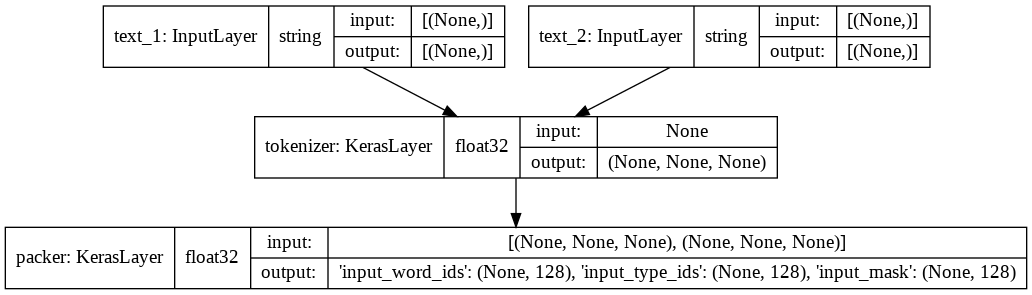

In [6]:
bert_preprocess_model = make_bert_preprocess_model(['text_1', 'text_2'])
keras.utils.plot_model(bert_preprocess_model, show_shapes=True, show_dtype=True)

In [7]:
def dataframe_to_dataset(dataframe):
    columns = ["text_1", "text_2", "label_idx"]
    dataframe = dataframe[columns].copy()
    ds = tf.data.Dataset.from_tensor_slices(dict(dataframe))
    return ds

In [8]:
batch_size = 32
auto = tf.data.AUTOTUNE

def prepare_dataset(df, training=True):
    ds = dataframe_to_dataset(df)
    if training:
        ds = ds.shuffle(len(train_df))
    
    ds = ds.batch(batch_size)
    ds = ds.map(lambda x: (bert_preprocess_model(x), x["label_idx"]))
    ds = ds.cache().prefetch(auto)
    return ds

train_ds = prepare_dataset(train_df)
test_ds = prepare_dataset(test_df, False)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:591: UserWarning: Input dict contained keys ['label_idx'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


In [9]:
# Reference:
# https://www.tensorflow.org/neural_structured_learning/tutorials/graph_keras_lstm_imdb
validation_fraction = 0.9
validation_size = int(validation_fraction *
                      int(len(train_df) / batch_size))
print(f"Validation samples: {validation_size}")
validation_ds = train_ds.take(validation_size)
train_ds = train_ds.skip(validation_size)

Validation samples: 33


## Model utilities

In [13]:
# Reference:
# https://www.tensorflow.org/text/tutorials/bert_glue
def build_classifier_model(num_classes=3):

  class Classifier(tf.keras.Model):
    def __init__(self, num_classes):
      super(Classifier, self).__init__(name="prediction")
      self.encoder = hub.KerasLayer(bert_model_path, trainable=False)
      self.dropout = keras.layers.Dropout(0.1)
      self.dense = keras.layers.Dense(num_classes)

    def call(self, preprocessed_text):
      encoder_outputs = self.encoder(preprocessed_text)
      pooled_output = encoder_outputs["pooled_output"]
      x = self.dropout(pooled_output)
      x = self.dense(x)
      return x

  model = Classifier(num_classes)
  return model

## Compile and train the model

In [14]:
classifier_model = build_classifier_model()
classifier_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")
history = classifier_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10
)

Epoch 1/10
5/5 [==============================] - 4s 151ms/step - loss: 2.2286 - accuracy: 0.7313 - val_loss: 2.4372 - val_accuracy: 0.8381
Epoch 2/10
5/5 [==============================] - 0s 115ms/step - loss: 2.1470 - accuracy: 0.8433 - val_loss: 1.9341 - val_accuracy: 0.8419
Epoch 3/10
5/5 [==============================] - 1s 224ms/step - loss: 1.8343 - accuracy: 0.8433 - val_loss: 1.5793 - val_accuracy: 0.8409
Epoch 4/10
5/5 [==============================] - 1s 199ms/step - loss: 0.9514 - accuracy: 0.8433 - val_loss: 1.2434 - val_accuracy: 0.8381
Epoch 5/10
5/5 [==============================] - 1s 125ms/step - loss: 0.9305 - accuracy: 0.8358 - val_loss: 1.1571 - val_accuracy: 0.8352
Epoch 6/10
5/5 [==============================] - 0s 122ms/step - loss: 1.0166 - accuracy: 0.8284 - val_loss: 1.1063 - val_accuracy: 0.8324
Epoch 7/10
5/5 [==============================] - 1s 231ms/step - loss: 1.0740 - accuracy: 0.7985 - val_loss: 1.1172 - val_accuracy: 0.8305
Epoch 8/10
5/5 [====

## Model evaluation

In [15]:
_, acc = classifier_model.evaluate(test_ds)
print(f"Accuracy on the test set: {round(acc * 100, 2)}%.")

7/7 [==============================] - 1s 14ms/step - loss: 1.0934 - accuracy: 0.8286
Accuracy on the test set: 82.86%.
